# Spark on GPU

Datalab also provide gpu, this notebook shows you how to use GPU in a spark session.


In [2]:
import os
from pyspark.sql import SparkSession

spark = (SparkSession 
         .builder
    
         .master("k8s://https://kubernetes.default.svc:443")
         # image des executors spark: pour des raisons de simplicité on réutilise l'image du notebook
         .config("spark.kubernetes.container.image", os.environ['IMAGE_NAME'])
         # Nom du namespace kubernetes
         .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])
         # Nombre d'executeur spark, il se lancera autant de pods kubernetes que le nombre indiqué.
         .config("spark.executor.instances", "5")
         # Mémoire alloué à la JVM
         # Attention par défaut le pod kubernetes aura une limite supérieur qui dépend d'autres paramètres.
         # On manipulera plus bas pour vérifier la limite de mémoire totale d'un executeur
         .config("spark.executor.memory", "4g")
         .config("spark.kubernetes.driver.pod.name", os.environ['KUBERNETES_POD_NAME'])
         
         # GPU specifique configuration
         .config("spark.executor.resource.gpu.amount", "1")
         .config("spark.task.resource.gpu.amount", "1")
         .config("spark.executor.resource.gpu.discoveryScript", "/opt/spark/examples/src/main/scripts/getGpusResources.sh")
         .config("spark.executor.resource.gpu.vendor", "nvidia.com")
         # spark.rapids.sql.enabled permet d'utiliser les gpus aussi pour les etapes SQL d'ETL. La pertinance de faire ça est à étudier => voir la vidéo mentionné en intro
         .config("spark.rapids.sql.enabled", "true")
         .config("spark.rapids.sql.incompatibleOps.enabled", "true")
         .config("spark.plugins", "com.nvidia.spark.SQLPlugin")
         .config("spark.rapids.force.caller.classloader", "false")

         .getOrCreate()
        )

sc = spark.sparkContext

# Nom du compte de service pour contacter l'api kubernetes : attention le package du datalab crée lui même cette variable d'enviromment.
# Dans un pod du cluster kubernetes il faut lire le fichier /var/run/secrets/kubernetes.io/serviceaccount/token
# Néanmoins ce paramètre est inutile car le contexte kubernetes local de ce notebook est préconfiguré
# conf.set("spark.kubernetes.authenticate.driver.serviceAccountName", os.environ['KUBERNETES_SERVICE_ACCOUNT']) 

# Paramètres d'enregistrement des logs spark d'application
# Attention ce paramètres nécessitent la création d'un dossier spark-history. Spark ne le fait pas lui même pour des raisons obscurs
# import s3fs
# endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
# fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})
# fs.touch('s3://tm8enk/spark-history/.keep')
# sparkconf.set("spark.eventLog.enabled","true")
# sparkconf.set("spark.eventLog.dir","s3a://tm8enk/spark-history")

#### Spark UI

Vous pouvez constaté sur la spark-ui ( voir le read me du service pour avoir le lien ) que les gpus sont alloués aux workers.
Parcontre je n'ai que 3 executeurs au lieu de 5 car probablement la plateforme n'a plus de GPU disponible.

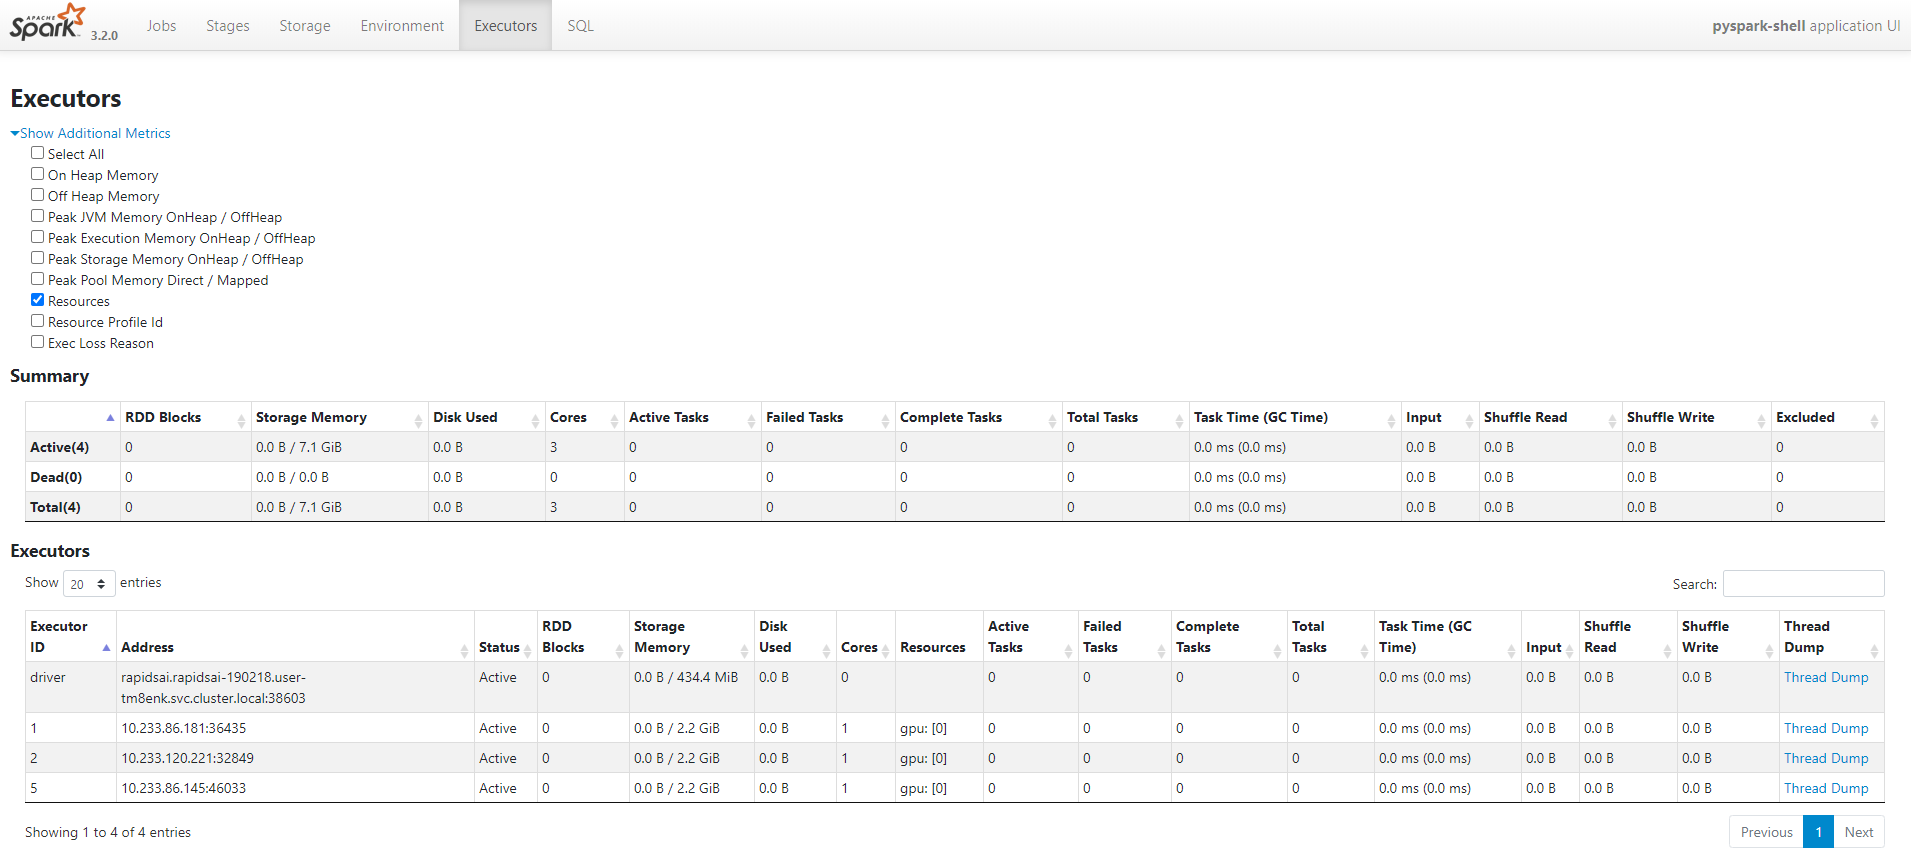

On peut vérifier avec kubernetes

In [5]:
#! kubectl get pods -l spark-role=executor

NAME                                    READY   STATUS    RESTARTS   AGE
pyspark-shell-2598057d7ff0a493-exec-1   1/1     Running   0          3h35m
pyspark-shell-2598057d7ff0a493-exec-2   1/1     Running   0          3h35m
pyspark-shell-2598057d7ff0a493-exec-3   0/1     Pending   0          3h35m
pyspark-shell-2598057d7ff0a493-exec-4   0/1     Pending   0          3h35m
pyspark-shell-2598057d7ff0a493-exec-5   1/1     Running   0          3h35m


On peut voir ici que deux pods ne se lancent, vérifions l'hypothèse

In [6]:
! kubectl describe pods pyspark-shell-2598057d7ff0a493-exec-4

Name:           pyspark-shell-2598057d7ff0a493-exec-4
Namespace:      user-tm8enk
Priority:       0
Node:           <none>
Labels:         spark-app-selector=spark-application-1638529018201
                spark-exec-id=4
                spark-exec-resourceprofile-id=0
                spark-role=executor
Annotations:    kubernetes.io/psp: default
Status:         Pending
IP:             
IPs:            <none>
Controlled By:  Pod/rapidsai-190218-f4fbdd6cc-vw55m
Containers:
  spark-kubernetes-executor:
    Image:      inseefrlab/rapidsai:main
    Port:       7079/TCP
    Host Port:  0/TCP
    Args:
      executor
    Limits:
      memory:          4505Mi
      nvidia.com/gpu:  1
    Requests:
      cpu:             1
      memory:          4505Mi
      nvidia.com/gpu:  1
    Environment:
      SPARK_USER:                 root
      SPARK_DRIVER_URL:           spark://CoarseGrainedScheduler@rapidsai.rapidsai-190218.user-tm8enk.svc.cluster.local:37405
      SPARK_EXECUTOR_CORES:       1
  

Sur les 15 noeuds de la plateforme, aucun n'a de GPU disponible.

#### Vérification en analysant le plan d'execution

Reprenons notre table Sirene

In [7]:
import json
from pyspark.sql.types import StructType

    
from pyspark import SQLContext
sqlContext=SQLContext(sc)
parquetDf = sqlContext.read.parquet("s3a://projet-spark-lab/diffusion/formation/data/sirene.parquet")
parquetDf.createOrReplaceTempView("sireneparquet")
parquetDfCount = sqlContext.sql("SELECT * FROM sireneparquet LIMIT 10")
parquetDFGroupBy= sqlContext.sql("SELECT count(*) as tot , activitePrincipaleEtablissement FROM sireneparquet group by activitePrincipaleEtablissement order by tot desc LIMIT 10")
%time print('comptage total : {}'.format(parquetDf.count()))
%time print('comptage des 10 premières lignes : {}'.format(parquetDfCount.count()))
%time parquetDFGroupBy.show()

/opt/spark/python/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


comptage total : 69911542
CPU times: user 546 µs, sys: 939 µs, total: 1.49 ms
Wall time: 4.47 s
comptage des 10 premières lignes : 10
CPU times: user 2.45 ms, sys: 0 ns, total: 2.45 ms
Wall time: 1.26 s
+--------+-------------------------------+
|     tot|activitePrincipaleEtablissement|
+--------+-------------------------------+
|11036361|                           null|
| 2822417|                         68.20B|
| 1724189|                          70.2C|
|  961082|                         70.22Z|
|  918291|                         68.20A|
|  760587|                         94.99Z|
|  730658|                         70.10Z|
|  727597|                          74.1J|
|  686920|                          85.1G|
|  650500|                          70.2A|
+--------+-------------------------------+

CPU times: user 3.48 ms, sys: 0 ns, total: 3.48 ms
Wall time: 2.54 s


In [8]:
parquetDfCount.explain()

== Physical Plan ==
CollectLimit 10
+- GpuColumnarToRow false
   +- GpuFileGpuScan parquet [siren#0,nic#1,siret#2L,dateFin#3,dateDebut#4,etatAdministratifEtablissement#5,changementEtatAdministratifEtablissement#6,enseigne1Etablissement#7,enseigne2Etablissement#8,enseigne3Etablissement#9,changementEnseigneEtablissement#10,denominationUsuelleEtablissement#11,changementDenominationUsuelleEtablissement#12,activitePrincipaleEtablissement#13,nomenclatureActivitePrincipaleEtablissement#14,changementActivitePrincipaleEtablissement#15,caractereEmployeurEtablissement#16,changementCaractereEmployeurEtablissement#17] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex[s3a://projet-spark-lab/diffusion/formation/data/sirene.parquet], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<siren:int,nic:int,siret:bigint,dateFin:string,dateDebut:string,etatAdministratifEtablissem...




In [10]:
parquetDf.explain()

== Physical Plan ==
GpuColumnarToRow false
+- GpuFileGpuScan parquet [siren#0,nic#1,siret#2L,dateFin#3,dateDebut#4,etatAdministratifEtablissement#5,changementEtatAdministratifEtablissement#6,enseigne1Etablissement#7,enseigne2Etablissement#8,enseigne3Etablissement#9,changementEnseigneEtablissement#10,denominationUsuelleEtablissement#11,changementDenominationUsuelleEtablissement#12,activitePrincipaleEtablissement#13,nomenclatureActivitePrincipaleEtablissement#14,changementActivitePrincipaleEtablissement#15,caractereEmployeurEtablissement#16,changementCaractereEmployeurEtablissement#17] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex[s3a://projet-spark-lab/diffusion/formation/data/sirene.parquet], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<siren:int,nic:int,siret:bigint,dateFin:string,dateDebut:string,etatAdministratifEtablissem...




In [9]:
parquetDFGroupBy.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- TakeOrderedAndProject(limit=10, orderBy=[tot#54L DESC NULLS LAST], output=[tot#54L,activitePrincipaleEtablissement#13])
   +- HashAggregate(keys=[activitePrincipaleEtablissement#13], functions=[count(1)])
      +- Exchange hashpartitioning(activitePrincipaleEtablissement#13, 200), ENSURE_REQUIREMENTS, [id=#460]
         +- HashAggregate(keys=[activitePrincipaleEtablissement#13], functions=[partial_count(1)])
            +- FileScan parquet [activitePrincipaleEtablissement#13] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[s3a://projet-spark-lab/diffusion/formation/data/sirene.parquet], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<activitePrincipaleEtablissement:string>




#### Conclusion

Nous avons bien recours au GPU pour faire du SQL, cela n'est pas évident sur la dernière requête mais si l'on regarde comment elle a été executé sur l'ihm spark, on constate bien que cela a tourné sur GPU.